In [27]:
import pandas as pd
import numpy as np

# Goal: forecast which countries will become top tourism destinations
# by predicting next-year international tourist arrivals.

world = pd.read_csv('world_tourism_economy_data.csv')
arrivals = pd.read_csv('international-tourist-arrivals.csv')

# Normalize/rename arrivals dataset columns
value_col = [c for c in arrivals.columns if c not in ['Entity', 'Code', 'Year']][0]
arrivals = arrivals.rename(
    columns={
        'Entity': 'country_name_arrivals',
        'Code': 'country_code',
        'Year': 'year',
        value_col: 'intl_arrivals',
    }
)

world['country_code'] = world['country_code'].astype(str).str.upper()
arrivals['country_code'] = arrivals['country_code'].astype(str).str.upper()

print('World rows:', world.shape)
print('Arrivals rows:', arrivals.shape)
print('World years:', int(world['year'].min()), int(world['year'].max()))
print('Arrivals years:', int(arrivals['year'].min()), int(arrivals['year'].max()))

World rows: (6650, 11)
Arrivals rows: (5043, 4)
World years: 1999 2023
Arrivals years: 1995 2020


In [28]:
# Merge by ISO3 + year (use overlapping years for model training/evaluation)
merged = world.merge(
    arrivals[['country_code', 'year', 'intl_arrivals']],
    on=['country_code', 'year'],
    how='inner',
)

merged = merged[(merged['year'] >= 1999) & (merged['year'] <= 2020)].copy()
merged = merged.sort_values(['country_code', 'year']).reset_index(drop=True)

merged[['country', 'country_code', 'year', 'intl_arrivals']].head()

,country,country_code,year,intl_arrivals
0,Aruba,ABW,1999,972000.0
1,Aruba,ABW,2000,1211000.0
2,Aruba,ABW,2001,1178000.0
3,Aruba,ABW,2002,1225000.0
4,Aruba,ABW,2003,1184000.0


In [29]:
# Feature engineering
# Economic/tourism ratios
merged['travel_balance'] = merged['tourism_receipts'] - merged['tourism_expenditures']
merged['receipts_per_arrival'] = merged['tourism_receipts'] / merged['tourism_arrivals']
merged['receipts_per_arrival'] = merged['receipts_per_arrival'].replace([np.inf, -np.inf], np.nan)

# Time-series features (per country)
merged['intl_arrivals_lag1'] = merged.groupby('country_code')['intl_arrivals'].shift(1)
merged['intl_arrivals_lag2'] = merged.groupby('country_code')['intl_arrivals'].shift(2)
merged['intl_arrivals_roll3'] = merged.groupby('country_code')['intl_arrivals'].transform(
    lambda s: s.shift(1).rolling(3, min_periods=3).mean()
)

# Target: next-year arrivals
merged['y_next_year'] = merged.groupby('country_code')['intl_arrivals'].shift(-1)

# Keep only rows where target exists (i.e., not the last year in each country series)
df_model = merged.dropna(subset=['y_next_year']).copy()

print('Model rows:', df_model.shape)
df_model[['country', 'country_code', 'year', 'intl_arrivals', 'y_next_year']].head()

Model rows: (3797, 18)


,country,country_code,year,intl_arrivals,y_next_year
0,Aruba,ABW,1999,972000.0,1211000.0
1,Aruba,ABW,2000,1211000.0,1178000.0
2,Aruba,ABW,2001,1178000.0,1225000.0
3,Aruba,ABW,2002,1225000.0,1184000.0
4,Aruba,ABW,2003,1184000.0,1304000.0


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Features for forecasting
feature_cols = [
    'intl_arrivals',
    'intl_arrivals_lag1',
    'intl_arrivals_lag2',
    'intl_arrivals_roll3',
    'tourism_receipts',
    'tourism_exports',
    'tourism_departures',
    'tourism_expenditures',
    'gdp',
    'inflation',
    'unemployment',
    'travel_balance',
    'receipts_per_arrival',
]

X = df_model[feature_cols]
y = df_model['y_next_year']

# Time-aware evaluation: train up to 2018, test on 2019 (normal year)
train_mask = df_model['year'] <= 2018
test_mask = df_model['year'] == 2019

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print('Train rows:', X_train.shape[0], 'Test rows:', X_test.shape[0])

# Baseline: predict next year equals this year's arrivals
baseline_pred = df_model.loc[test_mask, 'intl_arrivals'].values
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

ridge_model = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0, random_state=42)),
    ]
)

ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

results = pd.DataFrame([
    {'Model': 'Baseline (y[t])', 'MAE': baseline_mae, 'RMSE': baseline_rmse},
    {'Model': 'Ridge', 'MAE': ridge_mae, 'RMSE': ridge_rmse},
]).sort_values('RMSE')

results

Train rows: 3665 Test rows: 132


,Model,MAE,RMSE
0,Baseline (y[t]),9.810810e+06,2.311035e+07
1,Ridge,1.021016e+07,2.386863e+07


In [31]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)),
    ]
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

results = pd.concat(
    [
        results,
        pd.DataFrame([{'Model': 'RandomForest', 'MAE': rf_mae, 'RMSE': rf_rmse}]),
    ],
    ignore_index=True,
).sort_values('RMSE')

results

,Model,MAE,RMSE
0,Baseline (y[t]),9.810810e+06,2.311035e+07
2,RandomForest,1.002341e+07,2.314704e+07
1,Ridge,1.021016e+07,2.386863e+07


In [32]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for the evaluation year (2019 -> 2020 target)
plot_df = df_model.loc[test_mask, ['country', 'country_code', 'year', 'y_next_year']].copy()
plot_df['pred_ridge'] = ridge_pred
plot_df['pred_rf'] = rf_pred

# Show the countries with largest errors (optional quick diagnostic)
plot_df['abs_err_ridge'] = (plot_df['y_next_year'] - plot_df['pred_ridge']).abs()
plot_df.sort_values('abs_err_ridge', ascending=False).head(10)

,country,country_code,year,y_next_year,pred_ridge,pred_rf,abs_err_ridge
705,China,CHN,2019,30402000.0,1.669942e+08,1.606273e+08,1.365922e+08
3761,United States,USA,2019,45037000.0,1.715170e+08,1.659336e+08,1.264800e+08
1254,France,FRA,2019,117109000.0,2.206878e+08,2.109608e+08,1.035788e+08
1154,Spain,ESP,2019,36410000.0,1.279379e+08,1.292442e+08,9.152789e+07
1770,Italy,ITA,2019,38419000.0,9.657458e+07,9.624188e+07,5.815558e+07
1524,"Hong Kong SAR, China",HKG,2019,3569000.0,5.731403e+07,6.073845e+07,5.374503e+07
2342,Mexico,MEX,2019,51128000.0,9.837706e+07,9.630318e+07,4.724906e+07
1568,Croatia,HRV,2019,21608000.0,6.084302e+07,5.982619e+07,3.923502e+07
3632,Turkiye,TUR,2019,15971000.0,5.248372e+07,5.597700e+07,3.651272e+07
2226,"Macao SAR, China",MAC,2019,5897000.0,3.983397e+07,4.033595e+07,3.393697e+07


In [33]:
# Train final model on all available training rows up to 2019, then forecast 2021 using 2020 features
train_full = df_model[df_model['year'] <= 2019].copy()
forecast_base = merged[merged['year'] == 2020].copy()

# Recompute features on forecast_base to ensure lag features are present
forecast_base = forecast_base.sort_values(['country_code', 'year'])

# Keep only rows with the lag features available (some countries may have sparse series)
forecast_X = forecast_base[feature_cols]

# Choose best model by RMSE from results table
best_model_name = results.iloc[0]['Model']
if best_model_name == 'RandomForest':
    final_model = rf_model
else:
    final_model = ridge_model

final_model.fit(train_full[feature_cols], train_full['y_next_year'])
forecast_2021 = final_model.predict(forecast_X)

rank_df = forecast_base[['country', 'country_code', 'intl_arrivals']].copy()
rank_df.rename(columns={'intl_arrivals': 'intl_arrivals_2020'}, inplace=True)
rank_df['pred_intl_arrivals_2021'] = forecast_2021
rank_df['pred_growth'] = rank_df['pred_intl_arrivals_2021'] - rank_df['intl_arrivals_2020']

rank_df = rank_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['pred_intl_arrivals_2021'])
rank_df.sort_values('pred_intl_arrivals_2021', ascending=False).head(10)

,country,country_code,intl_arrivals_2020,pred_intl_arrivals_2021,pred_growth
1255,France,FRA,117109000.0,1.088787e+08,-8.230316e+06
2343,Mexico,MEX,51128000.0,4.713114e+07,-3.996857e+06
1771,Italy,ITA,38419000.0,3.452034e+07,-3.898662e+06
3762,United States,USA,45037000.0,3.432561e+07,-1.071139e+07
1155,Spain,ESP,36410000.0,3.096614e+07,-5.443859e+06
1612,Hungary,HUN,31641000.0,2.953437e+07,-2.106629e+06
706,China,CHN,30402000.0,2.025758e+07,-1.014442e+07
1569,Croatia,HRV,21608000.0,1.939005e+07,-2.217953e+06
1029,Denmark,DNK,15595000.0,1.450907e+07,-1.085929e+06
3633,Turkiye,TUR,15971000.0,1.437201e+07,-1.598989e+06


Top predicted destinations by arrivals (2021):


,country,country_code,intl_arrivals_2020,pred_intl_arrivals_2021,pred_growth
1255,France,FRA,117109000.0,1.088787e+08,-8.230316e+06
2343,Mexico,MEX,51128000.0,4.713114e+07,-3.996857e+06
1771,Italy,ITA,38419000.0,3.452034e+07,-3.898662e+06
3762,United States,USA,45037000.0,3.432561e+07,-1.071139e+07
1155,Spain,ESP,36410000.0,3.096614e+07,-5.443859e+06
1612,Hungary,HUN,31641000.0,2.953437e+07,-2.106629e+06
706,China,CHN,30402000.0,2.025758e+07,-1.014442e+07
1569,Croatia,HRV,21608000.0,1.939005e+07,-2.217953e+06
1029,Denmark,DNK,15595000.0,1.450907e+07,-1.085929e+06
3633,Turkiye,TUR,15971000.0,1.437201e+07,-1.598989e+06


Top predicted destinations by growth (2021 vs 2020):


,country,country_code,intl_arrivals_2020,pred_intl_arrivals_2021,pred_growth
3057,Qatar,QAT,582000.0,1.341852e+06,759851.508551
2183,Luxembourg,LUX,525000.0,1.180255e+06,655254.541394
2293,Moldova,MDA,29000.0,6.259048e+05,596904.846691
2077,St. Lucia,LCA,432500.0,9.933633e+05,560863.264748
3030,West Bank and Gaza,PSE,93000.0,6.230902e+05,530090.222903
2385,North Macedonia,MKD,118000.0,6.459520e+05,527952.022500
432,Bosnia and Herzegovina,BIH,197000.0,6.885230e+05,491522.981781
2847,Panama,PAN,647000.0,1.133626e+06,486626.396983
197,Australia,AUS,1828000.0,2.280018e+06,452018.092479
1437,Grenada,GRD,217000.0,6.538493e+05,436849.312348


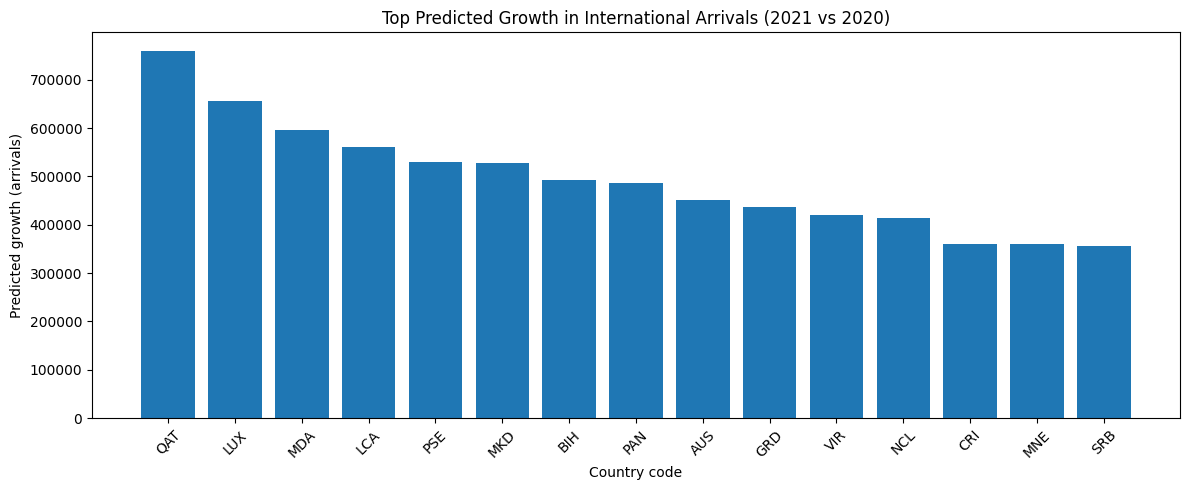

In [34]:
# Top destinations by predicted arrivals (2021)
top_by_arrivals = rank_df.sort_values('pred_intl_arrivals_2021', ascending=False).head(15)

# Top emerging destinations by predicted growth (2021 vs 2020)
top_by_growth = rank_df.sort_values('pred_growth', ascending=False).head(15)

print('Top predicted destinations by arrivals (2021):')
display(top_by_arrivals)

print('Top predicted destinations by growth (2021 vs 2020):')
display(top_by_growth)

plt.figure(figsize=(12, 5))
plt.bar(top_by_growth['country_code'], top_by_growth['pred_growth'])
plt.title('Top Predicted Growth in International Arrivals (2021 vs 2020)')
plt.xlabel('Country code')
plt.ylabel('Predicted growth (arrivals)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()